# 线性回归pytorch 实现
- 手动生成数据
- 加载数据
  要将顺序打乱，然后每次按照batch_size 的大小取出features 和labels，同时用yield生成器节省内存
- 定义模型
  也就是定义向前传播  或者说给出 features 来计算y_hat
- 初始化模型的参数，也就是w 和b
  重点是 requires_grad = True
- 定义损失函数
- 定义优化过程
  用的是sgd 随机梯度下降方法
- 然后就可以才是模型的训练了
  遍历每个epoch 然后不断取出数据，计算y_hat 计算loss ，backward, sgd，知道全部样本用完，则结束这一轮epoch
  再计算一边损失函数，注意torch.no_grad() 关闭计算图，节省内存，然后输出
  直到全部epoch 完成

scratch 抓取，也有从零开始的以上
concise 简洁，精简版本

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
import torch
from d2l import torch as d2l

### 首先要生成数据集
根据y = w *x + e

x 有两个特征，所以是一个num_example 行，2列的向量，
则w 也应该是两行一列的向量，才能进行相乘 也可以使用 一行两列的向量，pytorch 会自动处理

In [7]:
def sythetic_data(w,b,num_example):
    # 传入 设定好的w 和b，以及样本的数量，根据随机的x 计算出相应的y
    # 返回x和y
    x = torch.normal(0,1,(num_example,len(w)))
    y = torch.matmul(x,w) + b  # 矩阵乘法 mitrix multiplication torch会自动调整维度
    y += torch.normal(0,0.1,y.shape) #手动添加噪声 注意使用+= 避免内存开销
    return x,y.reshape(-1,1) # -1表示自动计算这个维度的大小，来保持不变


In [9]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features ,labels = sythetic_data(true_w,true_b,1000) # 有一千条样本
features[:10],labels[:10]

(tensor([[-2.0924,  0.8462],
         [-0.5449,  0.3640],
         [ 0.5697,  0.6784],
         [ 0.5349,  0.5259],
         [ 1.8371, -0.3520],
         [-0.4756, -0.5328],
         [ 0.7174, -2.3001],
         [-1.6538, -0.2188],
         [-1.7168, -1.6575],
         [-0.0110, -1.7144]]),
 tensor([[-2.8622],
         [ 1.9131],
         [ 3.0172],
         [ 3.3950],
         [ 9.0020],
         [ 4.8719],
         [13.4752],
         [ 1.5960],
         [ 6.3528],
         [10.1411]]))

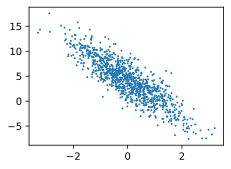

In [10]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### 读取数据集
按批次读取数据集

In [16]:
def data_iter(batch_size,features,labels):
    # 每次返回一个批次的 features 和labels
    num_example = len(features)
    indices = list(range(num_example))
    random.shuffle(indices)

    for i in range(0,num_example,batch_size):
        # 产生一个索引的张量
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_example)])
        yield features[batch_indices], labels[batch_indices]



In [17]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.5242,  0.0951],
        [-0.3081, -0.5202],
        [-0.4452, -0.9732],
        [ 0.6543, -1.7506],
        [ 1.0351, -0.1329],
        [-0.3337, -2.1121],
        [ 0.8196,  1.0028],
        [ 0.3479,  1.3466],
        [-0.6394,  2.3454],
        [ 0.9908,  0.7311]]) 
 tensor([[ 7.0159],
        [ 5.4202],
        [ 6.6926],
        [11.4700],
        [ 6.6837],
        [10.8206],
        [ 2.5248],
        [ 0.3018],
        [-4.9198],
        [ 3.6831]])


### 定义模型 也就是定义模型的前向传播，或者说计算过程

In [31]:
def linreg(x,w,b):
    return torch.matmul(x,w) + b


### 初始化模型参数

In [24]:
w = torch.normal(0,0.01,size = (2,1),requires_grad = True)
b = torch.zeros(1,requires_grad = True)

### 还有定义损失函数

In [35]:
def squared_loss(y_hat,y):
    return (y_hat - y.reshape(y_hat.shape)) **2 / (2 * len(y))

In [52]:
learn_rate = 0.03
num_epochs = 10
net = linreg
loss = squared_loss
# 定义一些超参数

### 还有优化过程或者说训练过程 也就是梯度下降

In [53]:
def sgd(params,lr):
    # 学名叫随机梯度下降方法
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad
            param.grad.zero_()

In [54]:
for epoch in range(num_epochs):
    for x,y in data_iter(batch_size,features,labels):
        l = loss(net(x,w,b),y)
        l.sum().backward()
        # .backward() 函数计算的是损失函数（一个标量值）相对于网络中所有参数的梯度。
        sgd([w,b],learn_rate)
    with torch.no_grad(): # 计算更新完梯度之后的损失函数，看看是否有效果，但是我们不需要求导，所以关闭计算图，节省内存
        train_l = loss(net(x,w,b),y)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000373
epoch 2, loss 0.000341
epoch 3, loss 0.000308
epoch 4, loss 0.000191
epoch 5, loss 0.000714
epoch 6, loss 0.000739
epoch 7, loss 0.000360
epoch 8, loss 0.000233
epoch 9, loss 0.000373
epoch 10, loss 0.000218


In [55]:
true_w,w,true_b,b

(tensor([ 2.0000, -3.4000]),
 tensor([[ 1.9984],
         [-3.3942]], requires_grad=True),
 4.2,
 tensor([4.1990], requires_grad=True))